In [796]:
%%html
<style>
table {float:left}
</style>

In [797]:
# my python files
import src.analytics as tics
import src.plotting_functions as pltfuncs
import src.transforms as trans
import src.hyp_test as hyp
import src.score_model as sc
import src.roc_curve as roc
import src.run_on_classifier as run



# Imports
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import kendalltau
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline, NaturalCubicSpline)
from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)
from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)
from sklearn.metrics import roc_curve, auc

%matplotlib inline

In [798]:
# On OSX requires brew install coreutils, using gshuf instead of shuf
sample_name = 'data/sample_random_subset.csv'
tics.create_random_samples('data/kddcup.data', 100000, sample_name)

df = trans.read_data(sample_name)

### Dropping Features


**Highly Correlated Features**

In [799]:
df = trans.drop_high_correlations(df)
trans.drop_zeros_columns(df)

#### Dropping irrelevant features
Considering that lasso is determining what features to keep (below), I decided to drop the suggested keepers until I get to a point where my logistic regression fails adequately.  This is an attempt to discern which features are derived

#### Then, trimming down a bit at a time

In [813]:
# # Uncomment to get a list of objects
# df_types = tics.get_dict_of_dtypes(df)
# objects = df_dtypes['object']
# objects
column_list = list(df.columns)

column_list

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'wrong_fragment',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'rerror_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_diff_srv_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_srv_serror_rate',
 'label']





#--------------------------------------------#
     Running classifier on ['duration']
#--------------------------------------------#


Modified Y to balance 1s and 0s
1    20664
0    20664
Name: attack_category, dtype: int64


True Positives: 4101
True Negatives: 307
False Positives: 3858
True Negatives: 0

Accuracy: 0.5332688120009679
Classification_error: 0.4667311879990322
Recall: 1.0
Precision: 0.5152657369016208
False Negative Rate: 0.0

confusion matrix
[[ 307 3858]
 [   0 4101]]




#--------------------------------------------#
     Running classifier on ['protocol_type']
#--------------------------------------------#


Modified Y to balance 1s and 0s
1    20664
0    20664
Name: attack_category, dtype: int64


True Positives: 2967
True Negatives: 4021
False Positives: 90
True Negatives: 1188

Accuracy: 0.8453907573191386
Classification_error: 0.15460924268086135
Recall: 0.7140794223826715
Precision: 0.9705593719332679
False Negative Rate: 0.28592057761732853

confusion mat



Modified Y to balance 1s and 0s
1    20664
0    20664
Name: attack_category, dtype: int64


True Positives: 4101
True Negatives: 18
False Positives: 4147
True Negatives: 0

Accuracy: 0.4983063150254053
Classification_error: 0.5016936849745948
Recall: 1.0
Precision: 0.4972114451988361
False Negative Rate: 0.0

confusion matrix
[[  18 4147]
 [   0 4101]]




#--------------------------------------------#
     Running classifier on ['rerror_rate']
#--------------------------------------------#


Modified Y to balance 1s and 0s
1    20664
0    20664
Name: attack_category, dtype: int64


True Positives: 3939
True Negatives: 306
False Positives: 3794
True Negatives: 227

Accuracy: 0.5135494797967578
Classification_error: 0.4864505202032422
Recall: 0.9455112818050888
Precision: 0.5093754041122462
False Negative Rate: 0.05448871819491118

confusion matrix
[[ 306 3794]
 [ 227 3939]]




#--------------------------------------------#
     Running classifier on ['diff_srv_rate']
#--------------

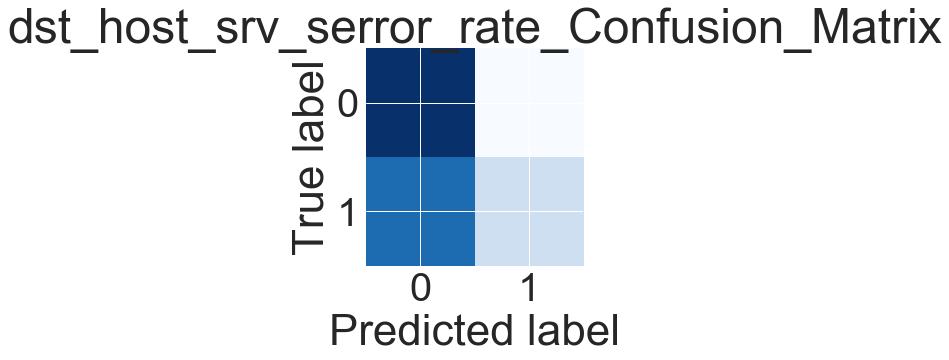

In [933]:
columns=['col', 'TN' ,'FP' ,
         'FN','TP','accuracy',
         'recall' ,'specificity', 
         'false_positive_rate', 'false_negative_rate',
         'precision', 
         ]

populate_conf_mat = {'col':[], 'TN':[], 'FP':[], 
                     'FN':[], 'TP':[], 'accuracy':[], 
                     'recall':[], 'specificity':[], 
                     'false_positive_rate':[],'false_negative_rate':[], 
                     'precision':[]
                    }

for col in column_list:
    # We don't want to run on this value
    if col == 'label':
        continue
        
    keep = [col]

    # logistic regression object
    classifier = LogisticRegression(penalty='l1')

    TN, FP, FN, TP, accuracy, recall, specificity, false_positive_rate, false_negative_rate, precision = run.run_classifier(df, keep, classifier)
    
    
    
    populate_conf_mat['col'].append(col)
    populate_conf_mat['TN'].append(TN)
    populate_conf_mat['FP'].append(FP)
    populate_conf_mat['FN'].append(FN)
    populate_conf_mat['TP'].append(TP)
    populate_conf_mat['accuracy'].append(accuracy)
    populate_conf_mat['recall'].append(recall)
    populate_conf_mat['specificity'].append(specificity)
    populate_conf_mat['false_positive_rate'].append(false_positive_rate)
    populate_conf_mat['false_negative_rate'].append(false_positive_rate)
    populate_conf_mat['precision'].append(precision)


conf_matrix_vals = pd.DataFrame(columns=columns)

# df = trans.drop_all_except(df, keep)



In [935]:
# title = 'Correlation Matrix of data after Dropping Correlated'
# pltfuncs.corr_heat(df, title)

# df.columns
# populate_conf_mat

In [936]:
conf_mat_df = pd.DataFrame(data=populate_conf_mat, columns=columns)

# df.columns
# g = sns.pairplot(df)
conf_mat_df.info()

# pltfuncs.plot_confusion_matrix(conf_mat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 11 columns):
col                    24 non-null object
TN                     24 non-null int64
FP                     24 non-null int64
FN                     24 non-null int64
TP                     24 non-null int64
accuracy               24 non-null float64
recall                 24 non-null float64
specificity            24 non-null float64
false_positive_rate    24 non-null float64
false_negative_rate    24 non-null float64
precision              24 non-null float64
dtypes: float64(6), int64(4), object(1)
memory usage: 2.1+ KB


In [937]:

# plt.barplot(conf_mat_df)
# conf_mat_df[''][conf_mat_df['col'] == 'duration'], title='Feature: Duration Confusion matrix', cmap=plt.cm.Blues)
conf_mat_df.head(30)

,col,TN,FP,FN,TP,accuracy,recall,specificity,false_positive_rate,false_negative_rate,precision
0,duration,307,3858,0,4101,0.533269,1.000000,0.073709,0.926291,0.926291,0.515266
1,protocol_type,4021,90,1188,2967,0.845391,0.714079,0.978108,0.021892,0.021892,0.970559
2,service,3772,410,21,4063,0.947859,0.994858,0.901961,0.098039,0.098039,0.908339
3,flag,4130,10,3192,934,0.612630,0.226369,0.997585,0.002415,0.002415,0.989407
4,src_bytes,410,3721,2435,1700,0.255263,0.411125,0.099250,0.900750,0.900750,0.313595
5,dst_bytes,2965,1175,1,4125,0.857730,0.999758,0.716184,0.283816,0.283816,0.778302
6,wrong_fragment,4046,0,4219,1,0.489596,0.000237,1.000000,0.000000,0.000000,1.000000
7,hot,21,4165,1,4079,0.496008,0.999755,0.005017,0.994983,0.994983,0.494784
8,num_failed_logins,4113,0,4153,0,0.497580,0.000000,1.000000,0.000000,0.000000,0.000000
9,logged_in,2877,1285,2,4102,0.844302,0.999513,0.691254,0.308746,0.308746,0.761463


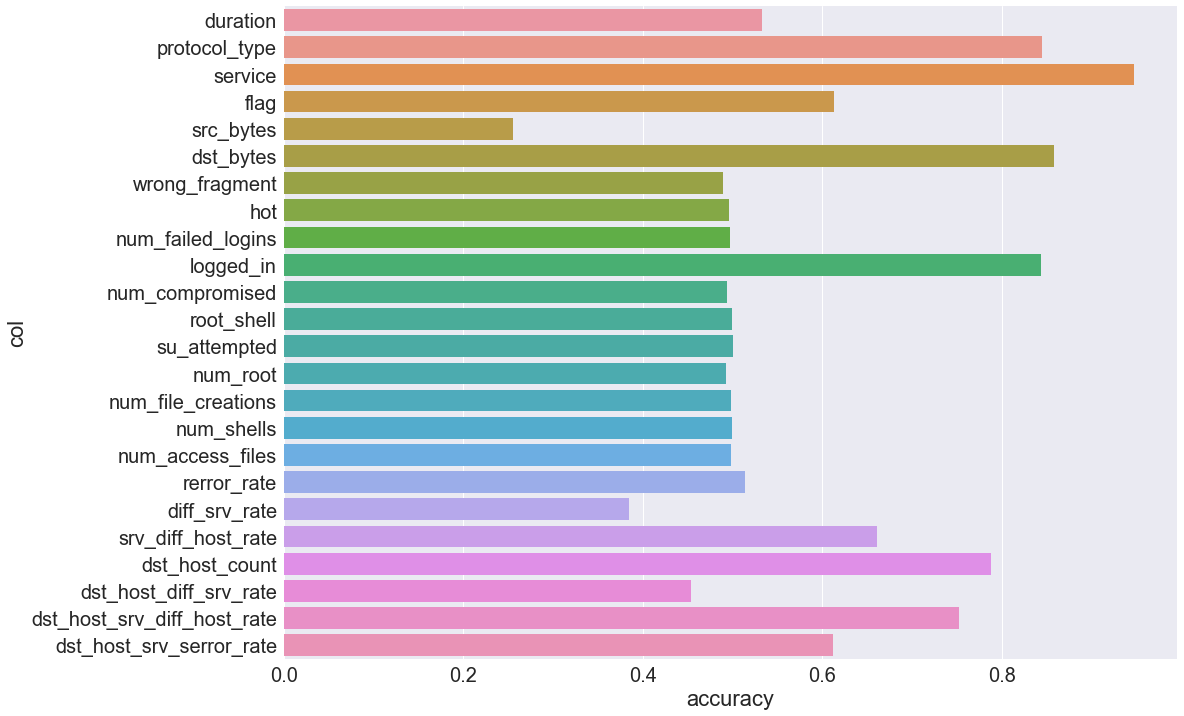

In [939]:

dims = (16, 12)
fig, ax = plt.subplots(figsize=dims)
ax = sns.barplot(x="accuracy", y="col", data=conf_mat_df)
sns.set_style("ticks")
sns.set()
sns.set(font_scale=2) 

Note that the feature with the single highest accuracy value using logistic regression is service.

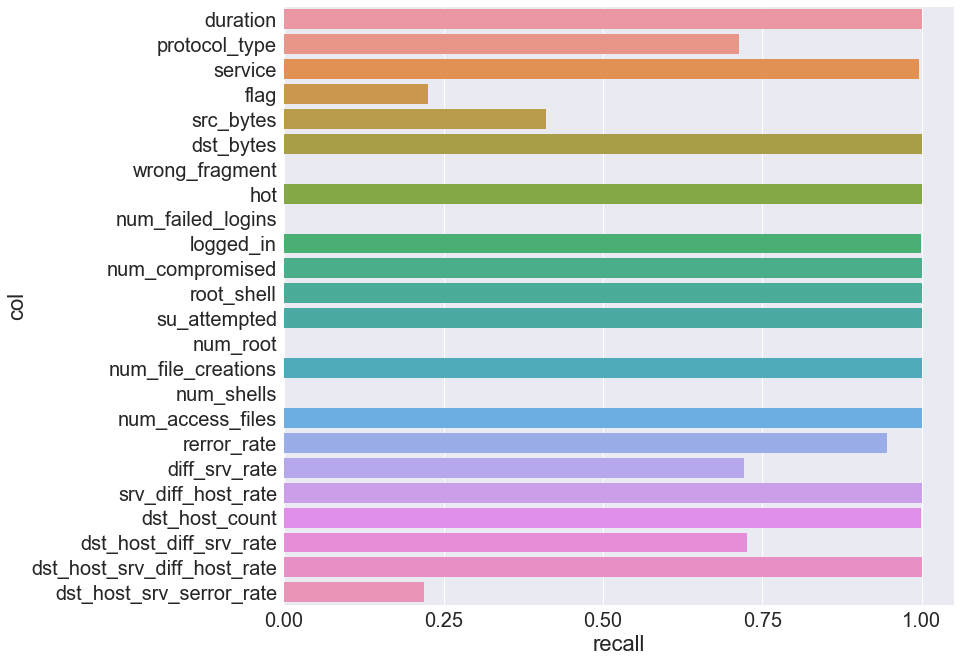

In [940]:
dims = (12, 11)
fig, ax = plt.subplots(figsize=dims)
ax = sns.barplot(x="recall", y="col", data=conf_mat_df)
sns.set_style("ticks")
sns.set()
sns.set(font_scale=4) 

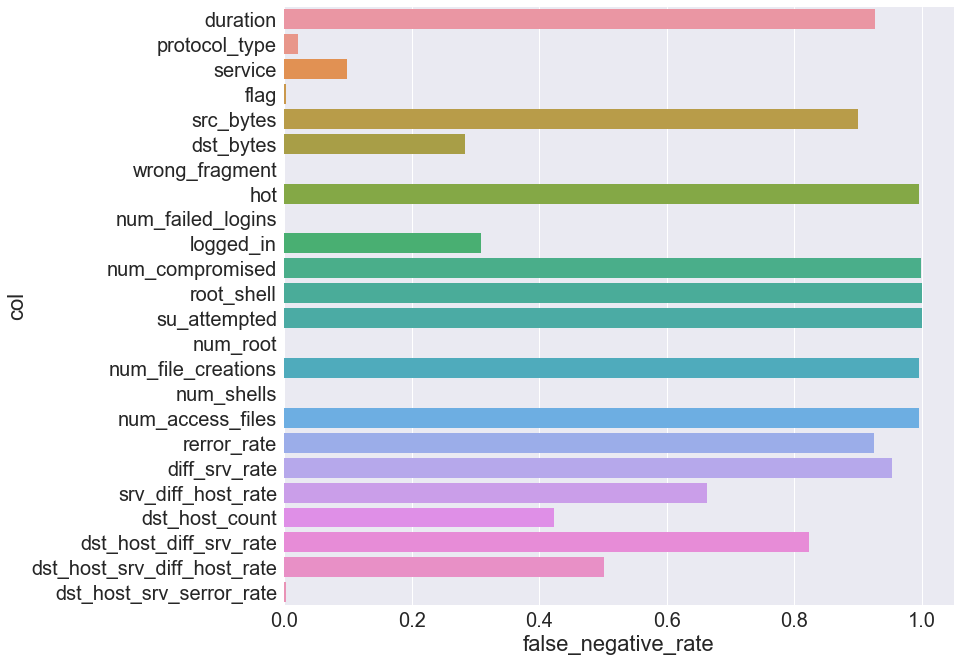

In [944]:
dims = (12, 11)
fig, ax = plt.subplots(figsize=dims)
ax = sns.barplot(x="false_negative_rate", y="col", data=conf_mat_df)
sns.set_style("ticks")
sns.set()
sns.set(font_scale=2) 

### Modeling
#### First try to get a simple logistic regression model working
- steps to get there
    - transform Label into its attack_category
    - transform attack_category into only DOS (2), the rest zero, as DOS is the most prevalent type
    - balance the data set by undersampling the more represented y

In [742]:
# # read in label names csv and send it as dictionary to mapping function
# label_names = ['label', 'attack_category', 'attack_cat_num']
# labels_loc = 'data/categories.csv'
# labels_to_categories = pd.read_csv(labels_loc, header=None)
# labels_to_categories.columns = label_names
# col_name = 'label'
# new_col_name = 'attack_category'

# df = trans.rewrite_values(df, dict(zip(labels_to_categories.label, labels_to_categories.attack_cat_num)), col_name, new_col_name)
# df['attack_category'].value_counts()

2    79235
0    19900
1      827
4       36
3        2
Name: attack_category, dtype: int64

In [743]:
# # rewrite all except attack_category types 2 to zero, put to new dataframe
# df = trans.rewrite_category2_to_zeros(df)
# # df2['attack_category'].value_counts()
# df.head()

,protocol_type,label,attack_category
0,icmp,smurf.,1
1,icmp,smurf.,1
2,tcp,neptune.,1
3,icmp,smurf.,1
4,icmp,smurf.,1


In [744]:
# df = trans.split_to_5050(df)
# df['attack_category'].value_counts()


removed 58470 rows


1    20765
0    20765
Name: attack_category, dtype: int64

In [697]:
# # drop label BEFORE running get dummies on data
# drop_if_in(df, 'label')
# 'label' in df

dropped label


False

In [698]:
# # if 'protocol_type' in df:
# df = pd.get_dummies(df)
# df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41932 entries, 75969 to 66253
Data columns (total 4 columns):
attack_category       41932 non-null int64
protocol_type_icmp    41932 non-null uint8
protocol_type_tcp     41932 non-null uint8
protocol_type_udp     41932 non-null uint8
dtypes: int64(1), uint8(3)
memory usage: 778.0 KB


In [699]:
# # Split X and Y
# y = df['attack_category']
# X = df.copy()

# # in order to not throw errors
# if 'attack_category' in X:
#     X.drop(['attack_category'], axis=1, inplace=True)
# if 'label' in X:
#     X.drop(['label'], axis=1, inplace=True)
    


Index(['protocol_type_icmp', 'protocol_type_tcp', 'protocol_type_udp'], dtype='object')

### Attempting logistic regression

In [700]:
# # Split the dataset into the Training set and Test set
# from sklearn.cross_validation import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#
# y_train.sum()
# len(y_train)

In [701]:
# from sklearn.preprocessing import StandardScaler
# sc_X = StandardScaler()
# X_train = sc_X.fit_transform(X_train)
# X_test = sc_X.transform(X_test)

In [702]:
# from sklearn.linear_model import LogisticRegression

# # logistic regression object
# classifier = LogisticRegression(penalty='l1')

# # teach classifier the correlations betw X_train and y_train
# classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [703]:
# # Predict the Test set results
# y_pred = classifier.predict(X_test) # vector giving prediction of each of the test set observations

True Positives: 3021
True Negatives: 4044
False Positives: 108
True Negatives: 1214

Accuracy: 0.8423751043281269
Classification_error: 0.15762489567187313
Recall: 0.7133412042502951
Precision: 0.965484180249281

confusion matrix
[[4044  108]
 [1214 3021]]


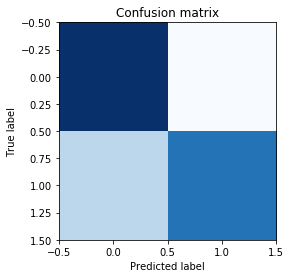

In [704]:
# pltfuncs.my_confusion_matrix(y_test, y_pred)

In [389]:
# lasso = Lasso()
# lasso.fit(X_train, y_train)

# print(lasso)
# print(lasso.coef_)
# # remove 0 coefficients 
# lasso.coef_

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
[ 0. -0. -0. -0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.
  0.  0. -0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0.  0. -0.  0.  0.
  0.  0.  0. -0. -0. -0. -0.  0.  0.  0.  0. -0. -0.  0. -0. -0.  0. -0.
 -0. -0. -0. -0.]


array([ 0., -0., -0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0., -0.,  0., -0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0.,  0., -0.,
        0.,  0.,  0.,  0.,  0., -0., -0., -0., -0.,  0.,  0.,  0.,  0.,
       -0., -0.,  0., -0., -0.,  0., -0., -0., -0., -0., -0.])

### Clean up below

In [ ]:
# from sklearn.datasets import make_classification
# from sklearn.linear_model import LogisticRegression
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y)


# # scaler = StandardScaler().fit(X_train)
# # X_train_1 = scaler.transform(X_train)
# # X_test_1 = scaler.transform(X_test)

# model = LogisticRegression(class_weight='balanced')
# model.fit(X_train, y_train)
# probabilities = model.predict_proba(X_test)[:, 1]

# # tpr, fpr, thresholds = roc.roc_curve(probabilities, y_test)
# tpr, fpr, thresholds = roc_curve(y_test, probabilities, pos_label=2)

# plt.plot(fpr, tpr)
# plt.xlabel("False Positive Rate (1 - Specificity)")
# plt.ylabel("True Positive Rate (Sensitivity, Recall)")
# plt.title("ROC plot of Logistic Regression Thresholds")
# plt.show()

### Attempting Lasso

In [ ]:
# scaler = StandardScaler()




scorer  = make_scorer(sc.rmsle, greater_is_better=True)

#How to manage many models
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledRidge', Pipeline([('Scaler', StandardScaler()),('EN', Ridge())])))

In [ ]:
# results = []
# names = []
# for name, model in pipelines:
#     kfold = KFold(n_splits=3, random_state=21)
#     cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scorer)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    
#     plt.plot(cv_results)
# #     plt.xlabel('n')
# #     plt.ylabel('rmse')
# #     plt.title('average test rmse vs sample size n');
    
#     print(msg)

## Run classifier on test data (has new features)

## make series of pairwise plots

## plug in knn